AGILE TEST LAB 
         --- coded by Xiaoyuan Cheng

In [447]:
import cvxpy as cp
import functools
import numpy as np
import pandas as pd
import datetime as DT
import matplotlib.pyplot as plt
import math
import pickle
import re
import sympy as sy
from scipy.optimize import minimize
import time
from itertools import islice

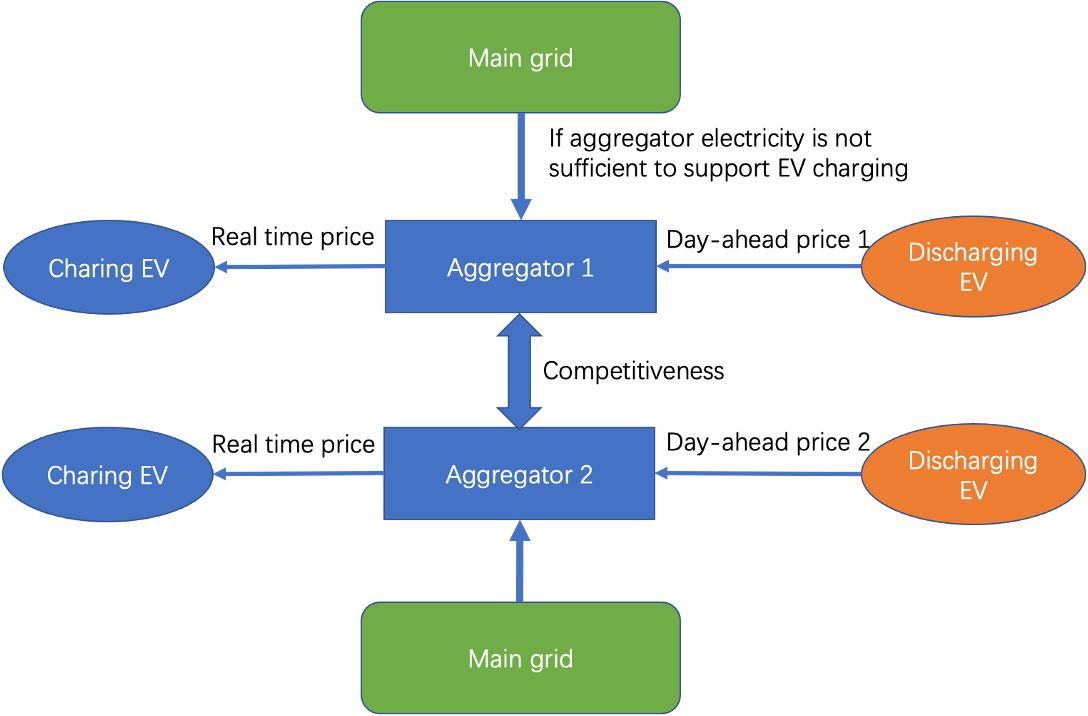

study framework 

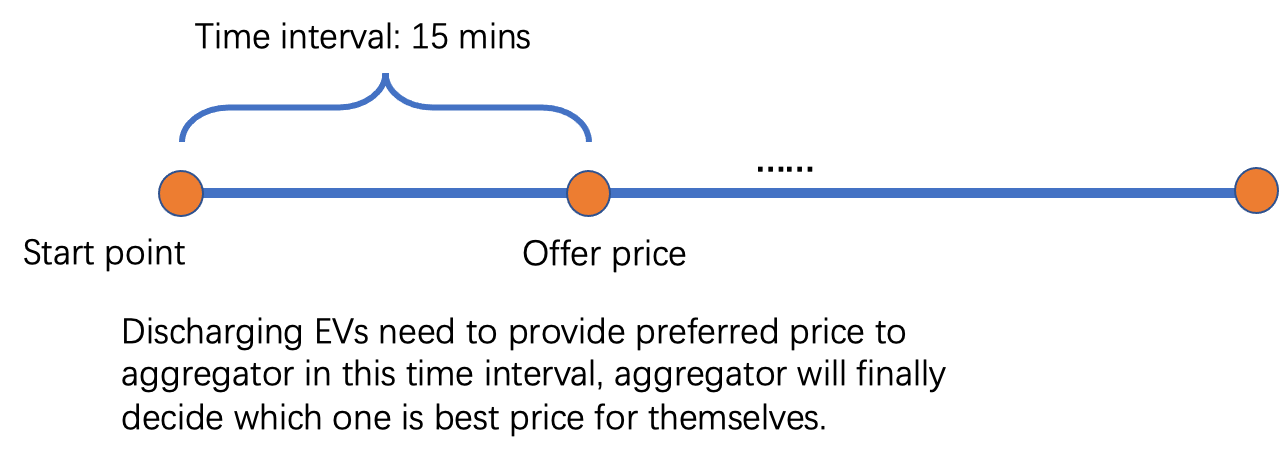

day-ahead price mechinism 

In [438]:
#function wrapper
def Xiaoyuan(func):
    @functools.wraps(func)
    def wrapper(*arg,**kw):
        time_1 = time.time()
        r = func(*arg, **kw)
        print('{} consumes {}ms'.format(func.__name__, 1000*(time.time()-time_1)))
        return r
    return wrapper

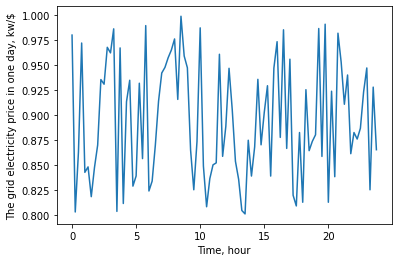

In [240]:
#define the real-time price of main grid electricity price
#time interval is 15 mins
time = [i/4 for i in range(24*4)]
grid_price = np.random.uniform(0.8,1,24*4)
fig = plt.plot(time,grid_price)
plt.xlabel('Time, hour')
plt.ylabel('The grid electricity price in one day, kw/$')
plt.show()

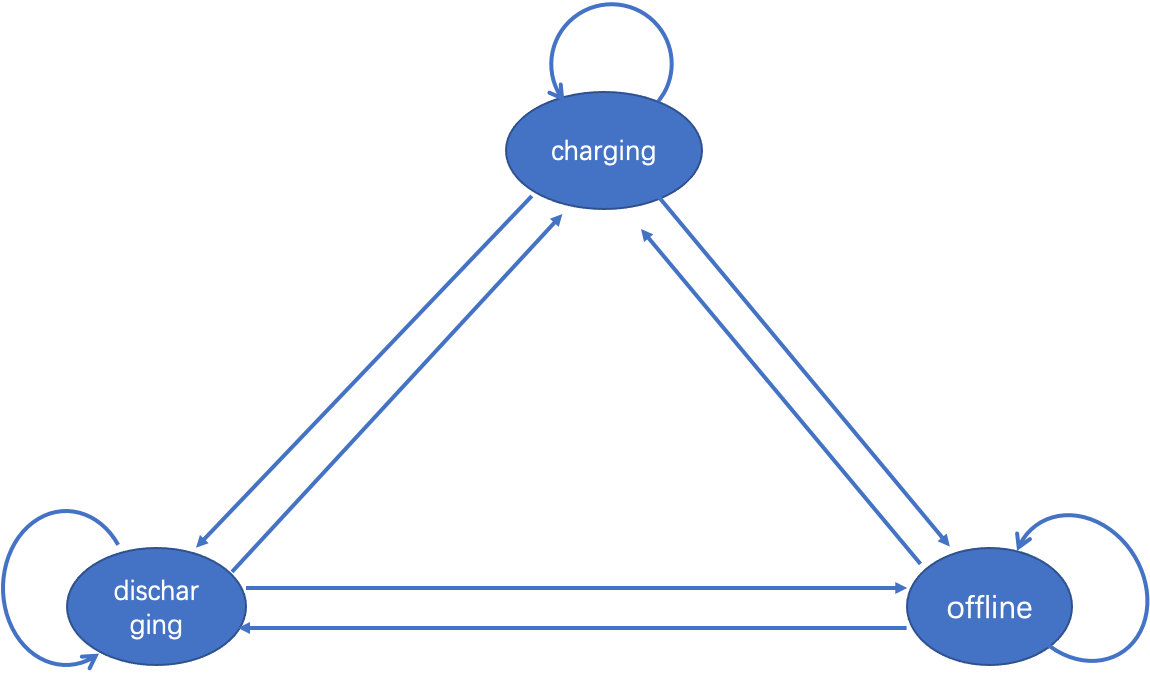

EV state mechanism

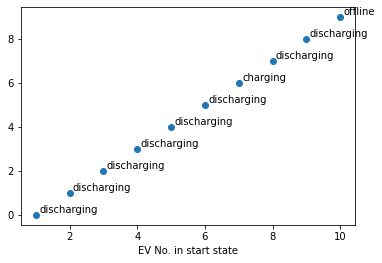

In [302]:
#define a case study of EVs behaviors in a time period
#here we use a discrete markov chain to simulate it, there is three states; charge, off-line and discharge
#use 'charging', 'offline', 'discharge' indicated the 
transition_matrix = np.array([[0.4,0.4,0.2],
                 [0.25,0.4,0.35],
                 [0.3,0.35,0.35]])


#you can check the state of each EV, I labeled each EV NO. and the start state
EV_No = [i for i in range(1,301)]
EV_start_state  =np.random.choice(['charging','offline','discharging'],300,[0.33,0.34,0.33])


#use an example to show you the case,just choose first 10 EVs
#x-bar is the No. of EV
x = EV_No[0:10]
y=[i for i in range(10)]
plt.scatter(x, y)
for i in range(len(x)):
    plt.annotate(EV_start_state[i], xy = (x[i], y[i]), xytext = (x[i]+0.1, y[i]+0.1)) 
    
plt.xlabel('EV No. in start state')
plt.show()

In [442]:
#define a function to describe the EV state in next time interval
@Xiaoyuan
def EV_state(EV_current_state, transition_matrix):
    next_EV_state = []
    for state in EV_current_state:
        if state == 'charging':
            next_state = np.random.choice(['charging','offline','discharging'], p = transition_matrix[0].ravel())
        elif state == 'offline':
            next_state = np.random.choice(['charging','offline','discharging'], p = transition_matrix[1].ravel())
        else:
            next_state = np.random.choice(['charging','offline','discharging'], p = transition_matrix[2].ravel())
        pass
        next_EV_state.append(next_state)
    return next_EV_state

#based on this function, simulate the dynamics of EVs' state in one day
if __name__ == '__main__':
    EV_state_matrix = []
    EV_current_state = EV_start_state
    # EV_state_matrix.append(EV_current_state)
    for i in range(4*24-1):
        EV_next_state = EV_state(EV_current_state, transition_matrix)
        EV_current_state = EV_next_state
        EV_state_matrix.append(EV_current_state)
        pass 

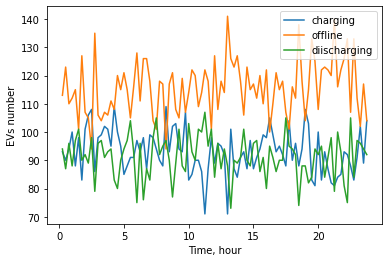

In [644]:
# EV states show
# np.array(EV_state_matrix).shape
# i = 0
# while i<=94:
#     print('in time {}  charging EVs: {}, offline EVs: {}, discharging EVs: {}'.format(i*0.25+0.25,
#                                                                                       EV_state_matrix[i].count('charging'), 
#                                                                                       EV_state_matrix[i].count('offline'),
#                                                                                       EV_state_matrix[i].count('discharging')))
charging = [EV_state_matrix[i].count('charging') for i in range(95)]
discharging = [EV_state_matrix[i].count('discharging') for i in range(95)]
plt.plot([i*0.25+0.25 for i in range(95)], [EV_state_matrix[i].count('charging') for i in range(95)])
plt.plot([i*0.25+0.25 for i in range(95)], [EV_state_matrix[i].count('offline') for i in range(95)])
plt.plot([i*0.25+0.25 for i in range(95)], [EV_state_matrix[i].count('discharging') for i in range(95)])
plt.legend(['charging', 'offline', 'diischarging'], loc='upper right')
plt.xlabel('Time, hour')
plt.ylabel('EVs number')
plt.show()

In [515]:
#define the aggregator characteristics
#in this case study, we assume there are two aggregators
#if it is feasible, then we extend to a larger scale 

#in a micro-grid, we define class type, each of aggregator will follows the defined class
class aggregator(object):
    start_storage = 0

    def __init__(self,input_power,output_power,storage_limitation,start_storage,t):
        self.input = input_power #charging power of EVs to aggregator
        self.output = output_power # required power of EVs
        self.storage_limitation = storage_limitation # limitation of aggregator SOC
        # aggregator.start_storage = start_storage # aggregator SOC
        self.t = t #time stamp
        if (self.input-self.output)>0 and self.start_storage < self.storage_limitation and (self.start_storage+0.25*(self.input-self.output))< self.storage_limitation:
            aggregator.start_storage += 0.25*(self.input-self.output)
            self.mode = 1 #represent the current behaviors of aggregator
            print('aggregator is charging')
        elif (self.input-self.output)>0 and self.start_storage < self.storage_limitation and (self.start_storage+0.25*(self.input-self.output))> self.storage_limitation:
            aggregator.start_storage = storage_limitation
            self.mode = 2
            print('aggregator is full after charging')
        elif (self.input-self.output)<0 and (self.start_storage - 0.25*(self.input-self.output))>0:
            aggregator.start_storage += -0.25*(self.input-self.output)
            self.mode = 3
            print('aggregator is discharging')
        elif (self.input-self.output)<0 and (self.start_storage - 0.25*(self.input-self.output))<0:
            aggregator.start_storage = 0
            self.mode = 4
            print('aggregator is purchasing electricity from main grid')
        else:
            print('errors, please check')
            pass
    
    def next_time_state(self):
        return self.input,self.output,self.storage_limitation,aggregator.start_storage,self.t,self.mode
    # def profit(self, offer_price, real_makret):
    #     if self.mode == 1:
    #         profit_state = 
        

here we have done a lot of jobs for preparing the boundaries, this part will enter into game theory to simulate the competitiveness among two aggregators

In [439]:
# we assume that the EVs are sensitive to historical trading price, here we use a relatively simple function to desribe EVs when 
#they choosing aggregators>> In the future, more complex functions can be employed, such as RNN, LSTM etc. 

#let's define two prices
#day_ahead_price, means the price EVs selling electricity to aggregators, our target is to optimize this value 
#real_market_price, means price aggregators selling to EVs, which is same to grid price

#then, define how many people will choose to different aggregators

@Xiaoyuan 
def EVs_num_aggregator_n(aggregator_1_current_price, aggregator_2_current_price,current_grid_price,t):
    num_1 = (current_grid_price - aggregator_1_current_price)/(2*current_grid_price - aggregator_2_current_price -aggregator_1_current_price)
    num_2 = (current_grid_price - aggregator_2_current_price)/(2*current_grid_price - aggregator_2_current_price -aggregator_1_current_price)
    return num_1, num_2

In [630]:
#liz mentioned the contract price should be set in a reasonable range
#in each time series, the day-ahead price should not beyond real-time price x in [0.6, current_grid_price)

#the detailed game theory process has been defined in my report, let's finished the last technical part

#for every step, each aggregator will try to find optimal price to maximize their profits, the function is:

# @Xiaoyuan

def fun(args):
    b,g,dis1,cha1,t = args
    v = lambda a: (g-a[0])/(2*g-a[0]-b)*(cha1*g-dis1*a[0])
    return v

def con(args1):
    x1min, x1max= args1
    cons = ({'type': 'ineq', 'fun': lambda x: x[0] - x1min},\
            {'type': 'ineq', 'fun': lambda x: -x[0] + x1max})
    return cons

In [635]:
# let's start the game, 
aggregator = [0.7]

args = (0.7,grid_price[1],discharging[0],charging[0],i) 
args1 = (0.6,grid_price[1]*1.2)
x0 = np.asarray([0.82])
res = minimize(fun(args), x0, method='SLSQP',constraints=con(args1))
aggregator.append(res.x[0])

for i in range(1,95):
    args = (res.x[0],grid_price[i+1],discharging[i],charging[i],i%2) 
    args1 = (0.6,grid_price[i]*1.2)
    x0 = np.asarray([0.82])
    res = minimize(fun(args), x0, method='SLSQP',constraints=con(args1))
    # print(res.fun)
    # print(res.success)
    # print(res.x)
    aggregator.append(res.x[0])

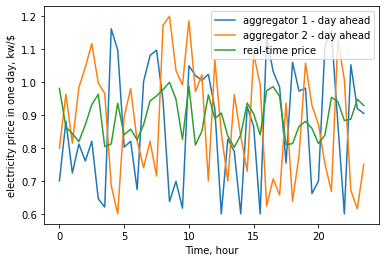

In [645]:
#the day-ahead price of aggregator is:
plt.plot([i*0.5 for i in range(48)], [aggregator[i*2] for i in range(48)])
plt.plot([i*0.5 for i in range(48)], [aggregator[i*2+1] for i in range(48)])
plt.plot([i*0.5 for i in range(48)], [grid_price[i*2] for i in range(48)])
plt.legend(['aggregator 1 - day ahead', 'aggregator 2 - day ahead', 'real-time price'], loc='upper right')
plt.xlabel('Time, hour')
plt.ylabel('electricity price in one day, kw/$')
plt.show()

please note, the orange and blue line is the price we wanted 